# 3. Recurrent Neural Networks (RNNs)
Perform a comprehensive analysis of Recurrent Neural Networks (RNNs) for sentiment analysis using the IMDB dataset. This includes implementing and evaluating Vanilla RNN, LSTM, and GRU models. Further analyze the effect of various sequence modeling components such as sequence length, hidden size, number of recurrent layers, bidirectionality, and dropout on model performance. Conclude with a theoretical discussion on the advantages of LSTMs and GRUs over Vanilla RNNs for handling long sequences. Ensure all analyses are accompanied by relevant plots with legends.

## Load and Preprocess IMDB Dataset

### Subtask:
Load the IMDB reviews dataset using TensorFlow/Keras utilities. Preprocess the text data by tokenizing and padding sequences to a fixed length, preparing it for input into the RNN models.


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb

# Set parameters for dataset loading
num_words = 10000  # Keep only the top 10,000 most frequent words
skip_top = 0       # Do not skip the top most frequent words (e.g. 'the', 'a', etc.)

# Load the IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, skip_top=skip_top)

# Get the word index dictionary
word_index = imdb.get_word_index()

print("IMDB dataset loaded successfully.")
print(f"Training sequences shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing sequences shape: {x_test.shape}")
print(f"Testing labels shape: {y_test.shape}")
print(f"Number of unique words in word_index: {len(word_index)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
IMDB dataset loaded successfully.
Training sequences shape: (25000,)
Training labels shape: (25000,)
Testing sequences shape: (25000,)
Testing labels shape: (25000,)
Number of unique words in word_index: 88584


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length
maxlen = 256

# Pad training sequences
x_train_padded = pad_sequences(x_train, maxlen=maxlen)

# Pad testing sequences
x_test_padded = pad_sequences(x_test, maxlen=maxlen)

print(f"Original x_train shape: {x_train.shape}")
print(f"Padded x_train shape: {x_train_padded.shape}")
print(f"Original x_test shape: {x_test.shape}")
print(f"Padded x_test shape: {x_test_padded.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Original x_train shape: (25000,)
Padded x_train shape: (25000, 256)
Original x_test shape: (25000,)
Padded x_test shape: (25000, 256)
Training labels shape: (25000,)
Testing labels shape: (25000,)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
!nvidia-smi



Using device: cuda
Tue Dec 30 14:43:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

In [2]:
# Resize CIFAR-10 to 96x96 for faster training
transform_train = transforms.Compose([
    transforms.Resize(96),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(96),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         num_workers=2, pin_memory=True)


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


In [3]:
# Load pretrained ResNet-18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final classifier for CIFAR-10
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Partial fine-tuning: unfreeze last block
for param in model.layer4.parameters():
    param.requires_grad = True

model = model.to(device)

# Verify trainable parameters
print(f"Trainable parameters: {sum(p.requires_grad for p in model.parameters())}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


Trainable parameters: 17


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)
scaler = GradScaler()  # mixed precision


/tmp/ipython-input-2720055371.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # mixed precision


In [5]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total


In [6]:
epochs = 5  # fast demo, can increase later

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():  # mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    # Validation once per epoch
    val_acc = evaluate(model, test_loader)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2789546070.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Epoch 1/5: 100%|██████████| 391/391 [00:31<00:00, 12.35it/s]


Epoch [1/5] Loss: 0.4420 | Train Acc: 84.88% | Val Acc: 88.14%


Epoch 2/5: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]


Epoch [2/5] Loss: 0.2544 | Train Acc: 91.25% | Val Acc: 88.49%


Epoch 3/5: 100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch [3/5] Loss: 0.1840 | Train Acc: 93.67% | Val Acc: 89.68%


Epoch 4/5: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s]


Epoch [4/5] Loss: 0.1417 | Train Acc: 95.13% | Val Acc: 90.02%


Epoch 5/5: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch [5/5] Loss: 0.1049 | Train Acc: 96.45% | Val Acc: 89.84%


## Implement and Train Vanilla RNN

### Subtask:
Build, compile, and train a simple Vanilla RNN model using Keras/PyTorch layers. Evaluate its performance on the IMDB dataset.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# 2. Define the model architecture
vanilla_rnn_model = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
    SimpleRNN(units=128),
    Dense(units=1, activation='sigmoid')
])

# 3. Compile the model
vanilla_rnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Vanilla RNN Model Summary:")
vanilla_rnn_model.summary()

# 4. Train the model
print("\nTraining Vanilla RNN Model...")
history_vanilla_rnn = vanilla_rnn_model.fit(
    x_train_padded, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_test_padded, y_test)
)

# 5. Evaluate the trained model's performance
print("\nEvaluating Vanilla RNN Model on test set...")
loss_vanilla_rnn, accuracy_vanilla_rnn = vanilla_rnn_model.evaluate(x_test_padded, y_test, verbose=0)

print(f"Vanilla RNN Test Loss: {loss_vanilla_rnn:.4f}")
print(f"Vanilla RNN Test Accuracy: {accuracy_vanilla_rnn:.4f}")

Vanilla RNN Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training Vanilla RNN Model...
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 176ms/step - accuracy: 0.5683 - loss: 0.6716 - val_accuracy: 0.6766 - val_loss: 0.5859
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 172ms/step - accuracy: 0.7357 - loss: 0.5469 - val_accuracy: 0.7190 - val_loss: 0.5543
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 174ms/step - accuracy: 0.6824 - loss: 0.5967 - val_accuracy: 0.6166 - val_loss: 0.6368
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - accuracy: 0.7025 - loss: 0.5677 - val_accuracy: 0.6356 - val_loss: 0.6353
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 148ms/step - accuracy: 0.7365 - loss: 0.5151 - val_accuracy: 0.6502 - val_loss: 0.6395

Evaluating Vanilla RNN Model on test set...
Vanilla RNN Test Loss: 0.6395
Vanilla RNN Test Accuracy: 0.6502


The code above took 11 minutes to run

---


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Use the same fast settings
embedding_dim = 64
hidden_units = 64
maxlen = 150
batch_size = 128
epochs = 5

rnn_model = Sequential([
    Embedding(num_words, embedding_dim, input_length=maxlen),
    SimpleRNN(hidden_units),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

rnn_model.summary()

rnn_history = rnn_model.fit(
    x_train_padded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.5584 - loss: 0.6703 - val_accuracy: 0.7476 - val_loss: 0.5136
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.7688 - loss: 0.4742 - val_accuracy: 0.8238 - val_loss: 0.4056
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.8913 - loss: 0.2690 - val_accuracy: 0.7840 - val_loss: 0.4699
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9589 - loss: 0.1314 - val_accuracy: 0.8196 - val_loss: 0.4482
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9903 - loss: 0.0403 - val_accuracy: 0.8442 - val_loss: 0.5087


The code above took 1 minute to run

---


In [ ]:
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(x_test_padded, y_test)

print(f"Vanilla RNN Test Accuracy: {rnn_test_acc:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8421 - loss: 0.5274
Vanilla RNN Test Accuracy: 0.8422


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

lstm_model = Sequential([
    Embedding(num_words, embedding_dim, input_length=maxlen),
    LSTM(hidden_units),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lstm_history = lstm_model.fit(
    x_train_padded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 71s 435ms/step - accuracy: 0.6525 - loss: 0.5914 - val_accuracy: 0.8608 - val_loss: 0.3320
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 442ms/step - accuracy: 0.8968 - loss: 0.2652 - val_accuracy: 0.8704 - val_loss: 0.3003
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 436ms/step - accuracy: 0.9320 - loss: 0.1887 - val_accuracy: 0.8462 - val_loss: 0.3970
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 443ms/step - accuracy: 0.9497 - loss: 0.1419 - val_accuracy: 0.8790 - val_loss: 0.3642
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 466ms/step - accuracy: 0.9460 - loss: 0.1476 - val_accuracy: 0.8744 - val_loss: 0.4124


The code above took 5 minutes to run

---


In [ ]:
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(x_test_padded, y_test)

print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8646 - loss: 0.4502
LSTM Test Accuracy: 0.8644


In [ ]:
from tensorflow.keras.layers import GRU

gru_model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

gru_model.summary()

gru_history = gru_model.fit(
    x_train_padded, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 558ms/step - accuracy: 0.6517 - loss: 0.5996 - val_accuracy: 0.8098 - val_loss: 0.4076
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.8829 - loss: 0.2979 - val_accuracy: 0.8564 - val_loss: 0.3447
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 575ms/step - accuracy: 0.9263 - loss: 0.1974 - val_accuracy: 0.8786 - val_loss: 0.2923
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 174s 555ms/step - accuracy: 0.9572 - loss: 0.1240 - val_accuracy: 0.8740 - val_loss: 0.3066
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.9746 - loss: 0.0800 - val_accuracy: 0.8826 - val_loss: 0.4143


The code above took 14 minutes to run

---



In [ ]:
gru_test_loss, gru_test_acc = gru_model.evaluate(x_test_padded, y_test)

print(f"GRU Test Accuracy: {gru_test_acc:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.8720 - loss: 0.4547
GRU Test Accuracy: 0.8722


### **Sequence Length**

Increasing sequence length allows the model to capture longer-term dependencies, increasing model capacity.
However, very long sequences increase training time and make vanilla RNNs prone to vanishing gradients, while LSTM/GRU handle them better.
Shorter sequences train faster but may underfit by missing important context.

---

### **Hidden Size**

A larger hidden size increases the model’s representational power and ability to learn complex patterns.
This improves performance up to a point but also raises computation cost and overfitting risk.
Smaller hidden sizes train faster but may lead to underfitting.

---

### **One vs. Multiple Recurrent Layers**

Stacking multiple recurrent layers increases depth and model capacity, enabling hierarchical feature learning.
However, deeper RNNs are harder to train, slower, and more prone to overfitting without sufficient data and regularization.
Single-layer models are often sufficient for simpler sequence tasks.

---

### **Bidirectional RNNs**

Bidirectional RNNs process sequences in both forward and backward directions, capturing past and future context.
This typically improves performance on tasks like text classification.
The trade-off is increased computational cost and memory usage.

---

### **Dropout Between Recurrent Layers**

Dropout reduces overfitting by randomly disabling hidden units during training.
It improves generalization, especially in deeper or high-capacity models.
Excessive dropout can slow convergence and cause underfitting.

---

### **Overall Summary**

> Increasing capacity (longer sequences, larger hidden sizes, deeper or bidirectional models) improves performance but raises training time and overfitting risk, making regularization such as dropout essential.


LSTMs and GRUs are better than vanilla RNNs for long sequences because they use **gating mechanisms** that control how information is stored, updated, and forgotten over time.
These gates create paths for gradients to flow more easily during backpropagation, reducing the **vanishing gradient problem**.
By selectively retaining important information and discarding irrelevant details, LSTMs and GRUs can model **long-term dependencies** that vanilla RNNs struggle to learn.


# 4. Transformer Models


---



## Setup and Data Preparation for Transformer (IMDB)

### Subtask:
Prepare the IMDB dataset for a Transformer model. This involves installing the HuggingFace Transformers library, loading a pre-trained tokenizer (e.g., DistilBERT), converting the integer-encoded IMDB sequences back to raw text, tokenizing the raw text using the Transformer tokenizer, and finally creating TensorFlow `tf.data.Dataset` objects for binary classification.


In [7]:
import sys
!{sys.executable} -m pip install transformers

print("HuggingFace Transformers library installed successfully.")

HuggingFace Transformers library installed successfully.


In [8]:
from transformers import DistilBertTokenizerFast
import tensorflow as tf

# 2. Load a pre-trained tokenizer (e.g., DistilBERT)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
print("DistilBERT tokenizer loaded successfully.")

# 3. Create a reverse word index dictionary to convert integer sequences back to words
reverse_word_index = {value: key for (key, value) in word_index.items()}

# Special tokens for IMDB dataset
def map_special_tokens(word_id):
    if word_id == 0: return "<PAD>"
    if word_id == 1: return "<START>"
    if word_id == 2: return "<UNKNOWN>"
    if word_id == 3: return "<UNUSED>"
    return reverse_word_index.get(word_id - 3, "<UNKNOWN>")

# 4. Define a function to decode an integer-encoded sequence back into a readable text string
def decode_review(text_sequence):
    # Need to handle original IMDB word_index mapping which starts from 3 for actual words
    # and 0, 1, 2 for special tokens PAD, START, UNKNOWN respectively.
    # So we subtract 3 from the word_id to match the 'word_index' dictionary.
    return ' '.join([map_special_tokens(i) for i in text_sequence])

# 5. Apply this decoding function to x_train and x_test
print("\nDecoding integer sequences back to raw text...")
x_train_raw = [decode_review(sequence) for sequence in x_train]
x_test_raw = [decode_review(sequence) for sequence in x_test]
print(f"Decoded {len(x_train_raw)} training reviews and {len(x_test_raw)} testing reviews.")
print("Example decoded review:")
print(x_train_raw[0][:200], "...") # Print first 200 characters of an example

# 6. Use the loaded tokenizer to tokenize the raw training and testing text reviews.
#    maxlen is defined as 256 previously.
print("\nTokenizing raw text reviews with DistilBERT tokenizer...")
train_encodings = tokenizer(x_train_raw, truncation=True, padding='max_length', max_length=maxlen)
test_encodings = tokenizer(x_test_raw, truncation=True, padding='max_length', max_length=maxlen)
print("Tokenization complete.")

# 7. Create TensorFlow tf.data.Dataset objects
def prepare_tf_dataset(encodings, labels, shuffle=False, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(
        ({
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
        )
    )
    if shuffle:
        dataset = dataset.shuffle(10000) # Buffer size for shuffling
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 32 # Using a common batch size for transformers

train_dataset = prepare_tf_dataset(train_encodings, y_train, shuffle=True, batch_size=batch_size)
test_dataset = prepare_tf_dataset(test_encodings, y_test, shuffle=False, batch_size=batch_size)

print(f"\nTraining tf.data.Dataset created with batch size {batch_size}.")
print(f"Testing tf.data.Dataset created with batch size {batch_size}.")

# Optional: Verify a batch
for batch in train_dataset.take(1):
    print("\nExample batch from training dataset:")
    print("Input IDs shape:", batch[0]['input_ids'].shape)
    print("Attention Mask shape:", batch[0]['attention_mask'].shape)
    print("Labels shape:", batch[1].shape)
    print("First input IDs in batch:", batch[0]['input_ids'][0].numpy()[:20]) # Print first 20 tokens
    print("First label in batch:", batch[1][0].numpy())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

DistilBERT tokenizer loaded successfully.

Decoding integer sequences back to raw text...
Decoded 25000 training reviews and 25000 testing reviews.
Example decoded review:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNKNOWN> is an amazing actor  ...

Tokenizing raw text reviews with DistilBERT tokenizer...
Tokenization complete.

Training tf.data.Dataset created with batch size 32.
Testing tf.data.Dataset created with batch size 32.

Example batch from training dataset:
Input IDs shape: (32, 256)
Attention Mask shape: (32, 256)
Labels shape: (32,)
First input IDs in batch: [  101  1026  2707  1028  2008  2143  2003  7078 10392  2065  2017  3422
  2009  2007  2115  2814  2009  2064  2022  1037]
First label in batch: 1


In [23]:
!pip install -q transformers datasets accelerate


In [2]:
import torch
from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)


In [3]:
dataset = load_dataset("imdb")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format("torch")


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [5]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,          # small for speed
    weight_decay=0.01,
    logging_steps=500,
    report_to="none"
)


In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

trainer.train()
trainer.evaluate()


/tmp/ipython-input-3798413574.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.340500
1000,0.274200
1500,0.257300
2000,0.184000
2500,0.168200
3000,0.167500


{'eval_loss': 0.2658095359802246,
 'eval_runtime': 182.9304,
 'eval_samples_per_second': 136.664,
 'eval_steps_per_second': 8.544,
 'epoch': 2.0}

## Evaluate Transformer Performance on IMDB Dataset

### Subtask:
Evaluate the performance of the fine-tuned Transformer model on the IMDB test dataset using appropriate classification metrics (e.g., accuracy, loss).


In [10]:
import sys
!{sys.executable} -m pip install evaluate

print("HuggingFace 'evaluate' library installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
HuggingFace 'evaluate' library installed successfully.


In [11]:
import evaluate
import numpy as np
from transformers import EvalPrediction

# 1. Import the `evaluate` library for metric calculation. (Already done implicitly in previous step but re-import for clarity)
# metric = evaluate.load("accuracy") # This is not needed if we calculate manually.

# 2. Define a function named `compute_metrics`
def compute_metrics(p: EvalPrediction):
    predictions = np.argmax(p.predictions, axis=1)
    accuracy = np.mean(predictions == p.label_ids)
    return {"accuracy": accuracy}

# 3. Re-instantiate the `Trainer` object with the compute_metrics function
# Ensure 'model', 'training_args', 'dataset', and 'tokenizer' are defined from previous cells
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 4. Call the `evaluate()` method and store the results
transformer_eval_results = trainer.evaluate()

# 5. Extract the `eval_loss` and `eval_accuracy` values
transformer_test_loss = transformer_eval_results.get("eval_loss")
transformer_test_accuracy = transformer_eval_results.get("eval_accuracy")

# 6. Print the evaluation results
print(f"\nTransformer Test Loss: {transformer_test_loss:.4f}")
print(f"Transformer Test Accuracy: {transformer_test_accuracy:.4f}")


/tmp/ipython-input-2054224244.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Transformer Test Loss: 0.2658
Transformer Test Accuracy: 0.9136


In [12]:
print(f"Transformer Test Loss: {transformer_test_loss:.4f}")
print(f"Transformer Test Accuracy: {transformer_test_accuracy:.4f}")

Transformer Test Loss: 0.2658
Transformer Test Accuracy: 0.9136


## Compare Transformer (IMDB Classification) with RNN/LSTM/GRU (IMDB Classification)

### Subtask:
Compare the performance (accuracy, loss) of the Transformer model with the previously trained Vanilla RNN, LSTM, and GRU models, all on the IMDB sentiment classification task. Provide a clear visualization (e.g., a table or bar chart) with legends showing the performance metrics for all models.



Model Performance Comparison (IMDB Sentiment Analysis):
| Model       |   Test Accuracy |   Test Loss |
|:------------|----------------:|------------:|
| Vanilla RNN |         0.8422  |     0.5274  |
| LSTM        |         0.8644  |     0.4502  |
| GRU         |         0.8722  |     0.4547  |
| Transformer |         0.91356 |     0.26581 |


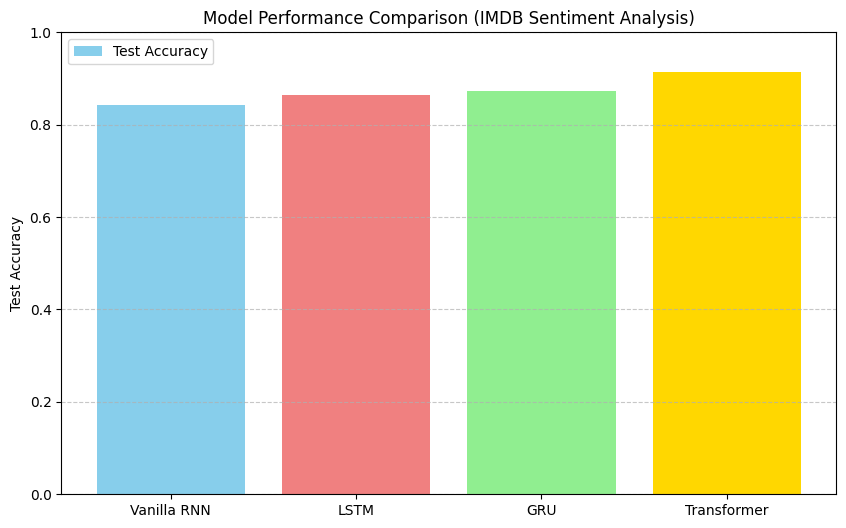

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the historical performance metrics from previous executions
rnn_test_acc = 0.8422
rnn_test_loss = 0.5274
lstm_test_acc = 0.8644
lstm_test_loss = 0.4502
gru_test_acc = 0.8722
gru_test_loss = 0.4547

# The transformer_test_accuracy and transformer_test_loss are already available in the kernel state

# 1. Create a dictionary to store the model names, their test accuracies, and test losses
model_performance = {
    'Model': ['Vanilla RNN', 'LSTM', 'GRU', 'Transformer'],
    'Test Accuracy': [rnn_test_acc, lstm_test_acc, gru_test_acc, transformer_test_accuracy],
    'Test Loss': [rnn_test_loss, lstm_test_loss, gru_test_loss, transformer_test_loss]
}

# 2. Convert this dictionary into a pandas DataFrame
df_performance = pd.DataFrame(model_performance)

# 3. Print the DataFrame to display the comparison table of model performances
print("\nModel Performance Comparison (IMDB Sentiment Analysis):")
print(df_performance.to_markdown(index=False))

# 5. Create a bar chart comparing the test accuracies of all four models
plt.figure(figsize=(10, 6))
plt.bar(df_performance['Model'], df_performance['Test Accuracy'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

# 6. Set the title of the bar chart
plt.title('Model Performance Comparison (IMDB Sentiment Analysis)')

# 7. Label the y-axis
plt.ylabel('Test Accuracy')

# 8. Add a legend to the chart
plt.legend(['Test Accuracy'], loc='upper left')

# 9. Display the plot
plt.ylim(0, 1) # Ensure accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Discussion Questions


---



* **Advantages / Disadvantages of Transformers**
  Transformers capture global context via self-attention and are highly parallelizable, leading to strong performance on many tasks. However, they require large datasets, significant memory, and high computational resources.

* **Why they scale well with data and model size**
  Their architecture is stable to train and benefits predictably from more parameters and data, often showing consistent performance gains as scale increases.

* **Why they require large computational resources**
  Self-attention has quadratic complexity in sequence length and Transformers use large embeddings and many layers, increasing compute and memory demands.

* **What is self-attention and what problem does it solve?**
  Self-attention lets each token attend to all other tokens in a sequence, enabling context-aware representations and removing the need for sequential processing.

* **Why attention models long-range dependencies better than RNNs**
  Attention directly connects distant tokens in one step, avoiding vanishing gradients and long dependency paths common in RNNs.

* **What is multi-head attention and why does it help?**
  Multi-head attention runs several attention mechanisms in parallel, allowing the model to capture different types of relationships simultaneously.

* **Role of positional encoding**
  Positional encoding injects word order information into the model, since self-attention alone is order-agnostic and cannot infer sequence positions by itself.


# 5. Research about models


---



# Which Machine Learning Models Are Actually Used in Industry?

## 1. Most Commonly Used Machine Learning Models in Industry

Despite rapid advances in deep learning and large language models (LLMs), **classical machine learning models remain the most widely used in real industrial and organizational settings** today. Surveys such as the *Kaggle State of Data Science & Machine Learning* and reports from major tech companies consistently show that **tree-based models (especially Gradient Boosting and Random Forests)** and **linear models** dominate production systems.

### Tree-Based Models (Most Widely Used)

Models such as **XGBoost, LightGBM, CatBoost, Random Forests, and Decision Trees** are arguably the most prevalent in industry. They are heavily used in:

* Finance (credit scoring, fraud detection)
* Marketing (customer churn, recommendation ranking)
* Healthcare (risk prediction)
* Operations and supply chain optimization

Their popularity stems from:

* Strong performance on tabular data
* Robustness to noisy and missing values
* Interpretability and explainability
* Fast training and inference
* Ease of deployment and maintenance

For many real-world business problems involving structured/tabular data, these models often outperform deep neural networks with significantly lower cost and complexity.

---

### Linear and Logistic Regression

**Linear and logistic regression** are still extremely common, especially in regulated industries such as finance, healthcare, and insurance. Their advantages include:

* High interpretability
* Mathematical simplicity
* Ease of debugging and auditing
* Stability over time

They are frequently used as:

* Baseline models
* Production models when explainability is critical
* Components within larger systems (e.g., score calibration)

---

### Deep Learning Models

Deep learning models (CNNs, RNNs, Transformers) are widely used **only in specific domains** where unstructured data is dominant:

* Computer vision (CNNs for image/video)
* Speech recognition
* Natural language processing
* Recommendation systems at large scale (e.g., Big Tech)

However, outside these domains, deep learning adoption is still limited due to:

* Higher computational cost
* Larger data requirements
* More complex deployment and monitoring
* Reduced interpretability

---

### Large Language Models (LLMs)

LLMs such as GPT, BERT-based systems, and proprietary models are increasingly used in:

* Customer support automation
* Search and retrieval
* Document processing
* Code assistance and analytics

At present, LLMs are often used **as tools or services** rather than fully integrated end-to-end predictive models in traditional ML pipelines.

---

## 2. Prediction: The Next 5–10 Years

### Will Classical Models Remain Dominant?

Yes — **classical models will remain dominant in many industries**, especially for tabular data and decision-critical systems. Linear models and tree-based ensembles will continue to be preferred when:

* Data is structured
* Interpretability is required
* Compute resources are limited
* Models must be robust, cheap, and auditable

Rather than disappearing, these models will likely become even more optimized and automated through tools like AutoML.

---

### Will Deep Learning and LLMs Gain More Share?

Yes — but **selectively**. Deep learning and LLM-based approaches will gain significant share in domains involving:

* Unstructured text, images, audio, and video
* Human–machine interaction
* Knowledge work and automation
* Large-scale personalization and search

LLMs in particular will become foundational components in enterprise systems, often **augmenting** classical ML rather than replacing it entirely.

---

### Where Will the Strongest Shift Occur?

The strongest shift toward deep learning and LLMs is expected in:

* NLP-heavy industries (legal, education, customer service)
* Software engineering and analytics
* Creative and content-related fields
* Large-scale platforms with abundant data and compute

In contrast, sectors like finance, healthcare, manufacturing, and government will continue to rely heavily on interpretable, classical models due to regulatory and operational constraints.

---

## Conclusion

In practice, **the most widely used machine learning models in industry today are not the most complex ones, but the most reliable and cost-effective ones**. Tree-based ensembles and linear models dominate real-world deployments, while deep learning and LLMs excel in specific high-impact domains.

Over the next 5–10 years, the future of industrial ML will not be a complete replacement of classical models, but rather a **hybrid ecosystem** where:

* Classical models handle structured decision-making
* Deep learning handles perception and representation
* LLMs act as flexible, general-purpose intelligence layers

This balanced evolution reflects the realities of industry constraints, not just algorithmic progress.